## Import Dependencies

In [50]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving emoji lexicon.csv to emoji lexicon.csv
User uploaded file "emoji lexicon.csv" with length 120151 bytes


In [1]:
!pip install -qq transformers accelerate

In [1]:
import re
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from transformers.data.processors.utils import InputFeatures

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
print(torch.__version__)
print(transformers.__version__)

2.2.1+cu121
4.40.2


## Loading, Analyzing IMDB Sentiment Dataset

In [5]:
df = pd.read_csv('/content/Finaloutput Last_LAST.csv')
df.shape

(1201, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1201 non-null   object
 1   label   1201 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


In [6]:
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

In [9]:
df.head(n=10)


,text,label
0,طيب ليش ماتطبقين السنة وتغيرين صورة هالمتبرجة ...,anger
1,حديث صحيح وصريح وانتهينا منك لانك تجادلين اجل ...,anger
2,ومين هالحمار الي يبي يرجعهم خلاص الوضع الطبيعي...,anger
3,صدقتي وع الله يعين صديقتي يتيمة عتيبية دايما ت...,anger
4,الحين تشوف قيادة المرأة لسيارتها المصائب والمن...,anger
5,احد الدعاة وجه يفكر ع فكرة حطيت صفحتين كتابين...,anger
6,الله يفشلكم وصل غسيلكم الوصخ وعنصريتكم النتنة ...,anger
7,عندهم اعتقاد اذا دافع عن مستشيخ بيكون شفيع له ...,anger
8,عذر اقبح ذنب,anger
9,انتوا تجيبون لروحكم عوار القلب الي يقول الرصيد...,anger


In [10]:
df.tail(n=10)

,text,label
1191,دينا غريبه شايفه ناس ترد السلام ع نفسهم استغفر...,suprise
1192,حالتي غريبه ماعندي صبر الفديو بدون ما اقدمه و ...,suprise
1193,وين بعارينك غريبه,suprise
1194,كنت امشي و مستغربه ليش كل شوي احس بدوخه تذكرت ...,suprise
1195,امس خلصت قضاء واليوم جتني الدوره اول مره حظي ي...,suprise
1196,أكثر شيء مستغربه منه كيف كذا نتابع نفس الأشخاص...,suprise
1197,مستغربة مرا كيف هالاثنين كانوا بعلاقة صدقية وف...,suprise
1198,حلاوه العيد كل يوم اخذ حبه وتخيلو كل يوم تطلع ...,suprise
1199,شيء جدا غريب بس بخاطري مرا اروح اشوف فرات السي...,suprise
1200,نمت سبعين مرا واحس باقي ماشبعت الموضوع غريب مه...,suprise


In [11]:
df[LABEL_COLUMN].value_counts()

label
sadness      151
anger        150
Neutral      150
fear         150
happiness    150
disgust      150
sarcasm      150
suprise      150
Name: count, dtype: int64

In [12]:
df = df.dropna(axis=0)
df.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
train_main, test_main = train_test_split(df, test_size=0.3, shuffle=True, random_state=SEED, stratify=df[LABEL_COLUMN])
label_list_main = list(df[LABEL_COLUMN].unique())

print("Training length: ", len(train_main))
print(train_main[LABEL_COLUMN].value_counts(), '\n')

print("Testing length: ", len(test_main))
print(test_main[LABEL_COLUMN].value_counts())

Training length:  840
label
happiness    105
fear         105
disgust      105
suprise      105
sarcasm      105
Neutral      105
anger        105
sadness      105
Name: count, dtype: int64 

Testing length:  361
label
sadness      46
anger        45
fear         45
disgust      45
suprise      45
Neutral      45
happiness    45
sarcasm      45
Name: count, dtype: int64


In [8]:
label_list_df_main = list(df[LABEL_COLUMN].unique())
print(label_list_df_main)

['anger', 'Neutral', 'sadness', 'fear', 'happiness', 'disgust', 'sarcasm', 'suprise']


## Clean and Prepare Dataset for input

In [9]:
class CustomDataset:

    def __init__(self, name: str, train: pd.DataFrame, test: pd.DataFrame, label_list: list[str]):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [10]:
data_main = CustomDataset("Project-Dataset", train_main, test_main, label_list_df_main)

In [11]:
print(data_main.name)
print(data_main.label_list)
print("Number of Labels:", len(data_main.label_list))

Project-Dataset
['anger', 'Neutral', 'sadness', 'fear', 'happiness', 'disgust', 'sarcasm', 'suprise']
Number of Labels: 8


In [12]:
nan_in_col = data_main.train[data_main.train[DATA_COLUMN].isnull()]
nan_in_col

,text,label


In [13]:
nan_in_col = data_main.test[data_main.test[DATA_COLUMN].isnull()]
nan_in_col

,text,label


In [14]:
data_main.train.head(n=10)

,text,label
736,يسعدني ويسرني أبلغكم المبلغ اكتمل وبإذن الله ا...,happiness
516,انقذوا امنه وجرموا العنف تلجأ الفتيات السعوديا...,fear
862,حتى البنات و هي تهد الصحه و تقلب الشكل و ريحه ...,disgust
1177,لازم احط حقوقي لو بصير ميمرز مب معقول الكل سرق...,suprise
978,لا السواق الي انتي متواعدة وياه وجه مبتسم قليلا,sarcasm
215,تسلم يا مولانا,Neutral
98,حسبي الله ونعم الوكيل والله شي يقهر ويعصب زوار...,anger
492,معذورة وربي جبانه واخاف,fear
263,فعلاً صوتها عادي مافيه ميزة وجه حائر اذا ماجا...,Neutral
982,ه جبهتها تشبه جبهة اقحطة وجه قطة بدموع فرح,sarcasm


##**Input Preproccessing**

In [51]:
import re
import pandas as pd

class TextProcessor:
    def __init__(self):
        self.arabic_diacritics_pattern = re.compile("[\u064B-\u065F\u0670\u0615-\u061A]")
        self.english_pattern = re.compile(r'[\dA-Za-z…]')
        self.english_characters_pattern = re.compile(r'[#@&%$!\(\)\{\}[\]:;.,،<>?؟`´''""\"''"""\[\]=+/\\|`''°~^*_-]')
        self.stop_word_comp = {"عدا","كأنها","إذا","اذا ",
                  "متى","لماذا","منذ","الان","الأن","فوق","فى","تحت","نحن","انا","أنا","الى","إلى","على","في"
                  ,"أمامك","اما","أمسى","أمّا","ان","أنت","أنتم","أنتما","أنتن","انت","أنشأ","أنّى","أو","أوشك","أولئك","عدا","ثم", "من","او","اما",
               "إنته", "أنتوا", "إنتو", "إنك", "إنكم", "إنها", "إنهم", "إنهن", "افا", "احنا", "انتي",
    "اليكي", "امكن", "اللي", "اشوه", "اش", "اللحين", "الحين", "اليك", "الو", "إيوا", "ايوه",
    "ايش", "انو", "اد", "اه", "اصلا", "اصلن", "بكيفه", "بكيفها", "بكيفهم",
    "بيقولو", "بتقول", "بتتكلم", "بردو", "برضو", "بجد", "بكل", "تو", "توي", "توهم",
    "تبا", "تاني", "حنا", "حوالينهم", "حيل", "حقيقي", "خليه", "خليهم",
    "خلينا", "خابر", "دوبي", "دوبه", "دوبها", "دوبهم", "دحين", "دائما", "دايم",
    "دامها", "دامنها", "دامهم", "دولي", "دولا", "دي", "ده", "دا", "ذحين", "ذالحين", "ذولي",
    "ذوان", "ذولا", "زي", "زيي", "زينا", "زيه", "زيها", "سم", "سمي", "شي", "شوي", "شوية",
    "شنو", "شلون", "صدق", "صراحتن", "صدچ", "طز", "علشان",
    "علاشان", "عشان", "عشانه", "عشانها", "عشانهم", "عليهم", "عنا", "فين", "فينه",
    "فينها", "فينكم", "فينهن", "قول", "قولوا", "قولو", "قم", "قدام", "قدامك", "قدامكم", "كله",
    "كلها", "كلهم", "كده", "كدا", "كنت", "كنتي", "كنتم", "كنتو", "كلش", "لأنه",
    "لأنو", "لكل", "لسه", "لسا", "لسى", "لسع", "ليه", "ليش", "معه", "معها", "معهم", "مدام",
    "مدامهم", "مهوب", "موب", "مش", "مو", "ماكو", "ممكن", "معاي", "معايا", "معاه", "معاها",
    "معانا", "معاهم", "مهب", "محد", "مااحد", "ماني", "مانبي", "نحنا", "هذول", "هذولي",
    "هذوليك", "هذلاك", "هذولاك", "هذاك", "هداك", "وشو", "وشهو", "وراهم", "ورى", "وراكم",
    "وش", "ويش", "وين", "وينه", "وينها", "وينهم", "وينكم", "يلا", "يله", "يلله"
}
        self.flag_mapping = {
        '🇦🇫': 'أفغانستان',
        '🇦🇱': 'ألبانيا',
        '🇩🇿': 'الجزائر',
        '🇦🇩': 'أندورا',
        '🇦🇴': 'أنغولا',
        '🇦🇬': 'أنتيغوا وبربودا',
        '🇦🇷': 'الأرجنتين',
        '🇦🇲': 'أرمينيا',
        '🇦🇼': 'أروبا',
        '🇦🇺': 'أستراليا',
        '🇦🇹': 'النمسا',
        '🇦🇿': 'أذربيجان',
        '🇧🇸': 'الباهاما',
        '🇧🇭': 'البحرين',
        '🇧🇩': 'بنغلاديش',
        '🇧🇧': 'بربادوس',
        '🇧🇾': 'بيلاروسيا',
        '🇧🇪': 'بلجيكا',
        '🇧🇿': 'بليز',
        '🇧🇯': 'بنين',
        '🇧🇹': 'بوتان',
        '🇧🇴': 'بوليفيا',
        '🇧🇦': 'البوسنة والهرسك',
        '🇧🇼': 'بوتسوانا',
        '🇧🇷': 'البرازيل',
        '🇧🇳': 'بروناي',
        '🇧🇬': 'بلغاريا',
        '🇧🇫': 'بوركينا فاسو',
        '🇧🇮': 'بوروندي',
        '🇰🇭': 'كمبوديا',
        '🇨🇲': 'الكاميرون',
        '🇨🇦': 'كندا',
        '🇨🇻': 'الرأس الأخضر',
        '🇰🇾': 'جزر كايمان',
        '🇨🇫': 'جمهورية أفريقيا الوسطى',
        '🇹🇩': 'تشاد',
        '🇨🇱': 'تشيلي',
        '🇨🇳': 'الصين',
        '🇨🇴': 'كولومبيا',
        '🇰🇲': 'جزر القمر',
        '🇨🇬': 'الكونغو - برازافيل',
        '🇨🇩': 'جمهورية الكونغو الديمقراطية',
        '🇨🇰': 'جزر كوك',
        '🇨🇷': 'كوستاريكا',
        '🇭🇷': 'كرواتيا',
        '🇨🇺': 'كوبا',
        '🇨🇾': 'قبرص',
        '🇨🇿': 'التشيك',
        '🇩🇰': 'الدانمارك',
        '🇩🇯': 'جيبوتي',
        '🇩🇲': 'دومينيكا',
        '🇩🇴': 'جمهورية الدومينيكان',
        '🇪🇨': 'الإكوادور',
        '🇪🇬': 'مصر',
        '🇸🇻': 'السلفادور',
        '🇬🇶': 'غينيا الاستوائية',
        '🇪🇷': 'إريتريا',
        '🇪🇪': 'إستونيا',
        '🇪🇹': 'إثيوبيا',
        '🇫🇯': 'فيجي',
        '🇫🇮': 'فنلندا',
        '🇫🇷': 'فرنسا',
        '🇬🇦': 'الغابون',
        '🇬🇲': 'غامبيا',
        '🇬🇪': 'جورجيا',
        '🇩🇪': 'ألمانيا',
        '🇬🇭': 'غانا',
        '🇬🇷': 'اليونان',
        '🇬🇩': 'غرينادا',
        '🇬🇹': 'غواتيمالا',
        '🇬🇳': 'غينيا',
        '🇬🇼': 'غينيا بيساو',
        '🇬🇾': 'غيانا',
        '🇭🇹': 'هايتي',
        '🇭🇳': 'هندوراس',
        '🇭🇺': 'المجر',
        '🇮🇸': 'أيسلندا',
        '🇮🇳': 'الهند',
        '🇮🇩': 'إندونيسيا',
        '🇮🇷': 'إيران',
        '🇮🇶': 'العراق',
        '🇮🇪': 'أيرلندا',
        '🇮🇱': 'إسرائيل',
        '🇮🇹': 'إيطاليا',
        '🇯🇲': 'جامايكا',
        '🇯🇵': 'اليابان',
        '🇯🇴': 'الأردن',
        '🇰🇿': 'كازاخستان',
        '🇰🇪': 'كينيا',
        '🇰🇮': 'كيريباتي',
        '🇽🇰': 'كوسوفو',
        '🇰🇼': 'الكويت',
        '🇰🇬': 'قيرغيزستان',
        '🇱🇦': 'لاوس',
        '🇱🇻': 'لاتفيا',
        '🇱🇧': 'لبنان',
        '🇱🇸': 'ليسوتو',
        '🇱🇷': 'ليبريا',
        '🇱🇾': 'ليبيا',
        '🇱🇮': 'ليختنشتاين',
        '🇱🇹': 'ليتوانيا',
        '🇱🇺': 'لوكسمبورغ',
        '🇲🇰': 'مقدونيا الشمالية',
        '🇲🇬': 'مدغشقر',
        '🇲🇼': 'مالاوي',
        '🇲🇾': 'ماليزيا',
        '🇲🇻': 'جزر المالديف',
        '🇲🇱': 'مالي',
        '🇲🇹': 'مالطا',
        '🇲🇭': 'جزر مارشال',
        '🇲🇷': 'موريتانيا',
        '🇲🇺': 'موريشيوس',
        '🇲🇽': 'المكسيك',
        '🇫🇲': 'ميكرونيزيا',
        '🇲🇩': 'مولدوفا',
        '🇲🇨': 'موناكو',
        '🇲🇳': 'منغوليا',
        '🇲🇪': 'الجبل الأسود',
        '🇲🇦': 'المغرب',
        '🇲🇿': 'موزمبيق',
        '🇲🇲': 'ميانمار',
        '🇳🇦': 'ناميبيا',
        '🇳🇷': 'ناورو',
        '🇳🇵': 'نيبال',
        '🇳🇱': 'هولندا',
        '🇳🇿': 'نيوزيلندا',
        '🇳🇮': 'نيكاراجوا',
        '🇳🇪': 'النيجر',
        '🇳🇬': 'نيجيريا',
        '🇰🇵': 'كوريا الشمالية',
        '🇳🇴': 'النرويج',
        '🇴🇴': 'جزر أورسي',
        '🇵🇰': 'باكستان',
        '🇵🇼': 'بالاو',
        '🇵🇸': 'فلسطين',
        '🇵🇦': 'بنما',
        '🇵🇬': 'بابوا غينيا الجديدة',
        '🇵🇾': 'باراغواي',
        '🇵🇪': 'بيرو',
        '🇵🇭': 'الفلبين',
        '🇵🇱': 'بولندا',
        '🇵🇹': 'البرتغال',
        '🇶🇦': 'قطر',
        '🇷🇴': 'رومانيا',
        '🇷🇺': 'روسيا',
        '🇷🇼': 'رواندا',
        '🇰🇳': 'سانت كيتس ونيفيس',
        '🇱🇨': 'سانت لوسيا',
        '🇻🇨': 'سانت فينسنت والغرينادين',
        '🇼🇸': 'ساموا',
        '🇸🇲': 'سان مارينو',
        '🇸🇹': 'ساو تومي وبرينسيبي',
        '🇸🇦': 'السعودية',
        '🇸🇳': 'السنغال',
        '🇷🇸': 'صربيا',
        '🇸🇨': 'سيشيل',
        '🇸🇱': 'سيراليون',
        '🇸🇬': 'سنغافورة',
        '🇸🇰': 'سلوفاكيا',
        '🇸🇮': 'سلوفينيا',
        '🇸🇧': 'جزر سليمان',
        '🇸🇴': 'الصومال',
        '🇿🇦': 'جنوب أفريقيا',
        '🇰🇷': 'كوريا الجنوبية',
        '🇸🇸': 'جنوب السودان',
        '🇪🇸': 'إسبانيا',
        '🇱🇰': 'سريلانكا',
        '🇸🇩': 'السودان',
        '🇸🇷': 'سورينام',
        '🇸🇿': 'سوازيلاند',
        '🇸🇪': 'السويد',
        '🇨🇭': 'سويسرا',
        '🇸🇾': 'سوريا',
        '🇹🇼': 'تايوان',
        '🇹🇯': 'طاجيكستان',
        '🇹🇿': 'تنزانيا',
        '🇹🇭': 'تايلاند',
        '🇹🇱': 'تيمور الشرقية',
        '🇹🇬': 'توغو',
        '🇹🇴': 'تونغا',
        '🇹🇹': 'ترينيداد وتوباغو',
        '🇹🇳': 'تونس',
        '🇹🇷': 'تركيا',
        '🇹🇲': 'تركمانستان',
        '🇹🇻': 'توفالو',
        '🇺🇬': 'أوغندا',
        '🇺🇦': 'أوكرانيا',
        '🇦🇪': 'الإمارات العربية المتحدة',
        '🇬🇧': 'المملكة المتحدة',
        '🇺🇸': 'الولايات المتحدة',
        '🇺🇾': 'أوروغواي',
        '🇺🇿': 'أوزبكستان',
        '🇻🇺': 'فانواتو',
        '🇻🇦': 'الفاتيكان',
        '🇻🇪': 'فنزويلا',
        '🇻🇳': 'فيتنام',
        '🇾🇪': 'اليمن',
        '🇿🇲': 'زامبيا',
        '🇿🇼': 'زيمبابوي',
    }
        self.emoji_dict = None

    def remove_arabic_diacritics(self, text):
        return self.arabic_diacritics_pattern.sub('', text)

    def remove_english_letters(self, text):
        return re.sub(self.english_pattern, '', text)

    def remove_english_characters(self, text):
        return re.sub(self.english_characters_pattern, '', text)

    def remove_stop_words(self, text):
        cleaned_row = [word for word in text.split() if word.strip() not in self.stop_word_comp]
        return ' '.join(cleaned_row)

    def replace_flags(self, text):
        for flag, country in self.flag_mapping.items():
            text = text.replace(flag, f"علم {country}")
        return text

    def load_emoji_meanings(self):
      emoji_data = pd.read_csv("/content/emoji lexicon.csv", encoding='utf-8')
      self.emoji_dict = dict(zip(emoji_data['emoji'], emoji_data['Meaning']))

    def translate_emojis(self, text):
        if self.emoji_dict is None:
            raise ValueError("Emoji meanings have not been loaded. Call 'load_emoji_meanings' method first.")

        translated_text = ""
        for char in text:
            if char in self.emoji_dict:
                translated_text += self.emoji_dict[char] + " "
            else:
                translated_text += char
        return translated_text

    def remove_duplicate_characters(self, text):
        cleaned_text = re.sub(r'(.)\1{2,}', r'\1', text)
        return cleaned_text

    def preprocess_text(self, texts):
        if self.emoji_dict is None:
            self.load_emoji_meanings()

        processed_texts = []
        for text in texts:
            # Remove Arabic diacritics
            text = self.remove_arabic_diacritics(text)
            # Remove English letters
            text = self.remove_english_letters(text)
            # Remove English characters
            text = self.remove_english_characters(text)
            # Remove stop words
            text = self.remove_stop_words(text)
            #replace flag
            text = self.replace_flags(text)
            # Translate emoji
            text = self.translate_emojis(text)
            # Remove duplicate characters
            text = self.remove_duplicate_characters(text)
            processed_texts.append(text)

        return processed_texts

##**Validating The input text and the calculate the percentage**

In [16]:
def validate_and_process_texts(texts):
    removedTexts=[]
    validtexts = []
    if len(texts)>1:  # Check if input is a list of texts
        for index, text in enumerate(texts):
            if not contains_arabic(text):
                print(f"Text {index + 1} is not valid: {text}")
                removedTexts.append(index)
            else:
              validtexts.append(text)

        return validtexts, removedTexts
    else:  # Single text input
        if not contains_arabic(texts):
            print("Text is not valid.")
            texts = []
            return texts, removedTexts

        return texts, removedTexts

def contains_arabic(text):
    # A basic check for Arabic characters
    return any('\u0600' <= ch <= '\u06FF' or '\u0750' <= ch <= '\u077F' or '\u08A0' <= ch <= '\u08FF' for ch in text)




In [17]:
import matplotlib.pyplot as plt

def percentage(result):
    NumberResult = len(result)
    AngerCount, SadCount, SurprisCount, NeutralCount, FearCount, DisgustCount, SarcasmCount, happyCount = 0, 0, 0, 0, 0, 0, 0, 0

    for i in result:
        if i == "suprise":
            SurprisCount += 1
        elif i == "happiness":
            happyCount += 1
        elif i == "sadness":
            SadCount += 1
        elif i == "Neutral":
            NeutralCount += 1
        elif i == "fear":
            FearCount += 1
        elif i == "disgust":
            DisgustCount += 1
        elif i == "sarcasm":
            SarcasmCount += 1
        elif i == "anger":
            AngerCount += 1

    AngerCount = (AngerCount / NumberResult) * 100
    SarcasmCount = (SarcasmCount / NumberResult) * 100
    DisgustCount = (DisgustCount / NumberResult) * 100
    FearCount = (FearCount / NumberResult) * 100
    NeutralCount = (NeutralCount / NumberResult) * 100
    SadCount = (SadCount / NumberResult) * 100
    happyCount = (happyCount / NumberResult) * 100
    SurprisCount = (SurprisCount / NumberResult) * 100

    labels = ['anger', 'Neutral', 'sadness', 'fear', 'happiness', 'disgust', 'sarcasm', 'suprise']
    sizes = [AngerCount, NeutralCount, SadCount, FearCount, happyCount, DisgustCount, SarcasmCount, SurprisCount]

    explode = (0.2, 0, 0, 0, 0, 0, 0, 0)
    fig = plt.figure(figsize=(10, 5))
    percent_labels = [f'{label} - {size:.1f}%' for label, size in zip(labels, sizes)]

    # Define custom blue colormap
    colors = plt.cm.Blues(np.linspace(0.2, 1, len(labels)))

    plt.pie(sizes, explode=explode, labels=None, startangle=140, colors=colors)
    plt.axis('equal')
    plt.legend(percent_labels, title="Emotions:", loc='center right')
    plt.show()

In [61]:
def input_text(egy):
  OldLength = len(egy)
  texts, removedTexts= validate_and_process_texts(egy)
  #print(len(texts))
  processor = TextProcessor()
  emotions = []
  i =0

  if(len(texts)==0):
    print("Try another text please.")
  elif(len(texts)==1):
    processed_text = processor.preprocess_text(texts)
    results = pipe(processed_text)
    for idx, result in enumerate(results):
      print(texts[idx], result)


  elif (len(texts)<OldLength and OldLength>1):
    print("Note: there is some texts that are invalid so it was not predicted ")
    processed_text = processor.preprocess_text(texts)
    results = pipe(processed_text)
    for idx, result in enumerate(results):
       print(texts[idx], result)
       emotions.append(result['label'])
    percentage(emotions)

  elif(len(texts)==OldLength and OldLength>1):
    processed_text = processor.preprocess_text(texts)
    results = pipe(processed_text)
    for idx, result in enumerate(results):
      print(texts[idx], result)
      emotions.append(result['label'])
    percentage(emotions)

## Tokenizing the Dataset and helper functions

In [19]:
model_name = 'UBC-NLP/MARBERTv2'

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
tokenizer.tokenize(" يارب اجبر كسر قلبي")

['يارب', 'اجبر', 'كسر', 'قلبي']

In [22]:
tokenizer.vocab_size

100000

In [29]:
tokenizer.get_vocab()

{'كج': 21286,
 'لذوق': 70655,
 'اخلاق': 5278,
 'تحرمنا': 11076,
 'حمدلله': 22481,
 'تعريص': 68586,
 'لقياد': 81598,
 'اسط': 6778,
 'ﺃﻛﺜﺮ': 40083,
 'نصل': 25095,
 'والسعاده': 20607,
 'النجاشي': 89611,
 'تمتزج': 90142,
 'الصادقة': 17712,
 'يتساءلون': 58529,
 '##رايز': 40892,
 'هالحزة': 68751,
 '##ﻤﺎﺀ': 40053,
 'داعي': 8019,
 'بالباطل': 35002,
 'جيوبنا': 79659,
 'كاننا': 26915,
 '##لازم': 56720,
 '##موث': 67198,
 'سمبوسه': 76863,
 '##تغريد': 84779,
 '##e': 1049,
 'ينقلب': 29317,
 'هندوسي': 90949,
 'ماعلمت': 77423,
 '##يعاب': 27870,
 'جهدي': 48711,
 'حفلة': 12232,
 'خلونا': 17816,
 'فلت': 10124,
 'والسي': 16857,
 '##as': 4788,
 'البش': 6117,
 '##اخذ': 11022,
 'ارضا': 22440,
 '##وقي': 5204,
 'مستقب': 8240,
 'تصلي': 13057,
 'لاتزغ': 39259,
 'ثقوا': 49261,
 '##موحة': 90752,
 'خليفة': 7908,
 'يحادون': 29123,
 'البانيا': 66977,
 'لاعبه': 60189,
 'بيروت': 11936,
 'ومحبوب': 94820,
 'كاز': 43026,
 'مبصرون': 97905,
 'تعالج': 34859,
 'لعام': 12296,
 'خيانة': 17479,
 'لاجمل': 38430,
 'هالم': 6866,
 '

In [23]:
max_len_train = max(len(tokenizer.tokenize(sentence)) for sentence in data_main.train[DATA_COLUMN].to_list())
max_len_test = max(len(tokenizer.tokenize(sentence)) for sentence in data_main.test[DATA_COLUMN].to_list())

max_len = max(max_len_train, max_len_test)
max_len

50

Training Sentence Lengths: 


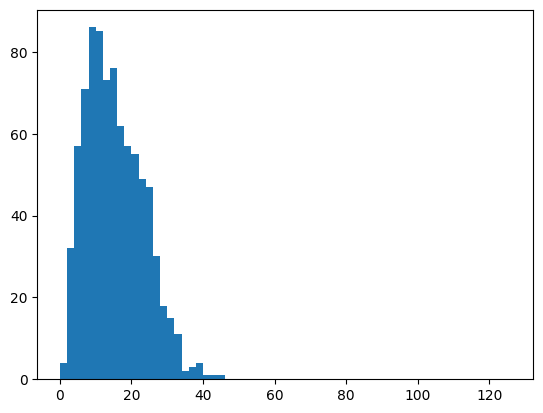

Testing Sentence Lengths: 


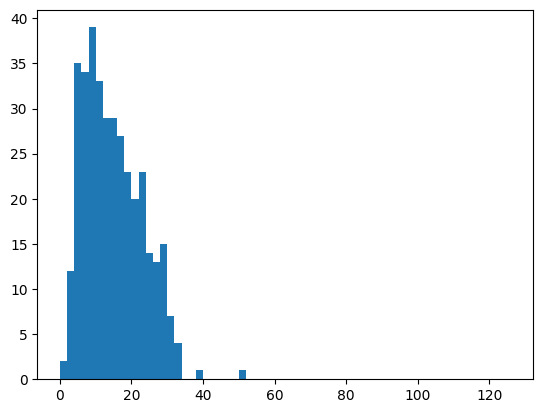

In [24]:
print("Training Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_main.train[DATA_COLUMN].to_list() ], bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_main.test[DATA_COLUMN].to_list() ], bins=range(0,128,2))
plt.show()



In [25]:
print("Truncated training sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.train[DATA_COLUMN].to_list()]))
print("Truncated testing sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  0
Truncated testing sequences:  0


In [26]:
print("Padded training sequences: ", sum([len(tokenizer.tokenize(sentence)) < max_len for sentence in data_main.train[DATA_COLUMN].to_list()]))
print("Padded testing sequences: ", sum([len(tokenizer.tokenize(sentence)) < max_len for sentence in data_main.test[DATA_COLUMN].to_list()]))

Padded training sequences:  840
Padded testing sequences:  360


In [27]:
class ClassificationDataset(Dataset):

    def __init__(self, text: list[str], target: list[str], model_name: str, max_len: int, label_map: dict[str, int]):
      super().__init__()

      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map

    def __len__(self):
      return len(self.text)

    def __getitem__(self, item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )

      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [28]:
label_map = { v:index for index, v in enumerate(data_main.label_list) }
print(label_map)

{'anger': 0, 'Neutral': 1, 'sadness': 2, 'fear': 3, 'happiness': 4, 'disgust': 5, 'sarcasm': 6, 'suprise': 7}


In [29]:
train_dataset = ClassificationDataset(
    data_main.train[DATA_COLUMN].to_list(),
    data_main.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

test_dataset = ClassificationDataset(
    data_main.test[DATA_COLUMN].to_list(),
    data_main.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

print(train_dataset[0])

InputFeatures(input_ids=[2, 14783, 4851, 1960, 14859, 17295, 30522, 15352, 1944, 2221, 2640, 13856, 37578, 27990, 4580, 2556, 8208, 2506, 2716, 2158, 4516, 21124, 1966, 3647, 14080, 2001, 46360, 1977, 5947, 2299, 2858, 2855, 8911, 2717, 14080, 2001, 46360, 1977, 5947, 2299, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], label=4)


In [30]:
input_ids = train_dataset[0].input_ids

tokenizer.decode(input_ids)

'[CLS] يسعدني ويسرني ابلغكم المبلغ اكتمل وباذن الله اليوم راح يصدر الشيك لشراء منزل لهم وراح يكون رمضان هذا بداية استقرارهموجه مبتسم مع عينين على شكل قلب شكرا لكل ساهم وجه مبتسم مع عينين على شكل قلب [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [31]:
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))
    return model

## Begin Regular Training

In [32]:
def compute_metrics(p):
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)

  print(classification_report(p.label_ids, preds))
  print()
  print(confusion_matrix(p.label_ids, preds))

  macro_f1 = f1_score(p.label_ids, preds, average='macro')
  macro_precision = precision_score(p.label_ids, preds, average='macro')
  macro_recall = recall_score(p.label_ids, preds, average='macro')
  accuracy = accuracy_score(p.label_ids, preds)

  return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': accuracy
  }

In [43]:
pip install transformers[torch]

In [44]:
!pip install accelerate==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.30.1
    Uninstalling accelerate-0.30.1:
      Successfully uninstalled accelerate-0.30.1


In [42]:
pip install accelerate -U

  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [33]:
from transformers import TrainingArguments
import accelerate
training_args = TrainingArguments(
    output_dir="train",
    logging_dir="logs",
    evaluation_strategy="epoch",
    per_device_train_batch_size=22,
    per_device_eval_batch_size=22,
    gradient_accumulation_steps=1,
    num_train_epochs=10,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    adam_beta1=0.9,
    adam_beta2=0.999,
    adam_epsilon=1e-8,
    fp16=True,
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True
)


In [34]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
1,No log,1.929536,0.439471,0.458961,0.454529,0.454294
2,No log,1.358331,0.616039,0.641854,0.645048,0.645429
3,No log,0.888226,0.750331,0.770976,0.761413,0.761773
4,No log,0.711083,0.797003,0.803592,0.800302,0.800554
5,No log,0.646492,0.790224,0.797708,0.791908,0.792244
6,No log,0.684175,0.803855,0.816624,0.803019,0.803324
7,No log,0.759119,0.800150,0.808433,0.805797,0.806094
8,No log,0.742669,0.819016,0.827151,0.819686,0.819945
9,No log,0.740378,0.810328,0.819247,0.811353,0.811634
10,No log,0.751197,0.807061,0.814682,0.808575,0.808864


              precision    recall  f1-score   support

           0       0.27      0.09      0.13        45
           1       0.33      0.38      0.35        45
           2       0.61      0.37      0.46        46
           3       0.47      0.36      0.41        45
           4       0.68      0.60      0.64        45
           5       0.52      0.64      0.57        45
           6       0.36      0.64      0.46        45
           7       0.44      0.56      0.49        45

    accuracy                           0.45       361
   macro avg       0.46      0.45      0.44       361
weighted avg       0.46      0.45      0.44       361


[[ 4  2  0  6  0 12 17  4]
 [ 2 17  2  0  4  3  9  8]
 [ 1  5 17  6  1  6  6  4]
 [ 1  6  6 16  2  1  2 11]
 [ 0  8  0  4 27  2  3  1]
 [ 2  4  1  0  0 29  9  0]
 [ 3  4  0  1  3  1 29  4]
 [ 2  5  2  1  3  2  5 25]]
              precision    recall  f1-score   support

           0       0.56      0.11      0.19        45
           1       0.5

TrainOutput(global_step=390, training_loss=0.6153949444110577, metrics={'train_runtime': 91.9048, 'train_samples_per_second': 91.399, 'train_steps_per_second': 4.244, 'total_flos': 215844914880000.0, 'train_loss': 0.6153949444110577, 'epoch': 10.0})

## Finetuned Model Evaluation

In [36]:
trainer.evaluate()

              precision    recall  f1-score   support

           0       0.63      0.80      0.71        45
           1       0.91      0.67      0.77        45
           2       0.93      0.91      0.92        46
           3       0.84      0.91      0.87        45
           4       0.86      0.93      0.89        45
           5       0.87      0.89      0.88        45
           6       0.68      0.60      0.64        45
           7       0.90      0.84      0.87        45

    accuracy                           0.82       361
   macro avg       0.83      0.82      0.82       361
weighted avg       0.83      0.82      0.82       361


[[36  0  1  0  0  4  3  1]
 [ 4 30  0  1  2  0  8  0]
 [ 2  0 42  2  0  0  0  0]
 [ 0  0  2 41  1  0  0  1]
 [ 0  0  0  1 42  1  1  0]
 [ 5  0  0  0  0 40  0  0]
 [ 8  3  0  2  2  1 27  2]
 [ 2  0  0  2  2  0  1 38]]


{'eval_loss': 0.7426685094833374,
 'eval_macro_f1': 0.8190157134020153,
 'eval_macro_precision': 0.827150982870785,
 'eval_macro_recall': 0.8196859903381642,
 'eval_accuracy': 0.8199445983379502,
 'eval_runtime': 0.368,
 'eval_samples_per_second': 980.908,
 'eval_steps_per_second': 46.192,
 'epoch': 10.0}

## Saving the finetuned BERT model and tokenizer for model inference

In [37]:
print(label_map)

inv_label_map = { v:k for k, v in label_map.items()}

print(inv_label_map)

{'anger': 0, 'Neutral': 1, 'sadness': 2, 'fear': 3, 'happiness': 4, 'disgust': 5, 'sarcasm': 6, 'suprise': 7}
{0: 'anger', 1: 'Neutral', 2: 'sadness', 3: 'fear', 4: 'happiness', 5: 'disgust', 6: 'sarcasm', 7: 'suprise'}


In [38]:
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map

SAVE_PATH = 'Arabic_Bert'

In [39]:
trainer.save_model(SAVE_PATH)
train_dataset.tokenizer.save_pretrained(SAVE_PATH)

('Arabic_Bert/tokenizer_config.json',
 'Arabic_Bert/special_tokens_map.json',
 'Arabic_Bert/vocab.txt',
 'Arabic_Bert/added_tokens.json',
 'Arabic_Bert/tokenizer.json')

## Classification Report and Confusion Matrix

In [40]:
pipe = pipeline(task="text-classification", model=SAVE_PATH, device=device, max_length=max_len, truncation=True, padding='max_length')

In [41]:
tests = data_main.test[LABEL_COLUMN].to_list()
results = pipe(data_main.test[DATA_COLUMN].to_list())

preds = [res['label'] for res in results]

print("Real Testing Dataset labels: ", tests[:10])
print("Predicted Testing Dataset labels: ", preds[:10])

Real Testing Dataset labels:  ['anger', 'disgust', 'fear', 'suprise', 'disgust', 'disgust', 'sadness', 'Neutral', 'disgust', 'suprise']
Predicted Testing Dataset labels:  ['anger', 'disgust', 'fear', 'suprise', 'disgust', 'anger', 'sadness', 'Neutral', 'anger', 'suprise']


In [42]:
print(classification_report(tests, preds))

              precision    recall  f1-score   support

     Neutral       0.91      0.67      0.77        45
       anger       0.63      0.80      0.71        45
     disgust       0.87      0.89      0.88        45
        fear       0.84      0.91      0.87        45
   happiness       0.86      0.93      0.89        45
     sadness       0.93      0.91      0.92        46
     sarcasm       0.68      0.60      0.64        45
     suprise       0.90      0.84      0.87        45

    accuracy                           0.82       361
   macro avg       0.83      0.82      0.82       361
weighted avg       0.83      0.82      0.82       361



In [43]:
list(label_map)

['anger',
 'Neutral',
 'sadness',
 'fear',
 'happiness',
 'disgust',
 'sarcasm',
 'suprise']

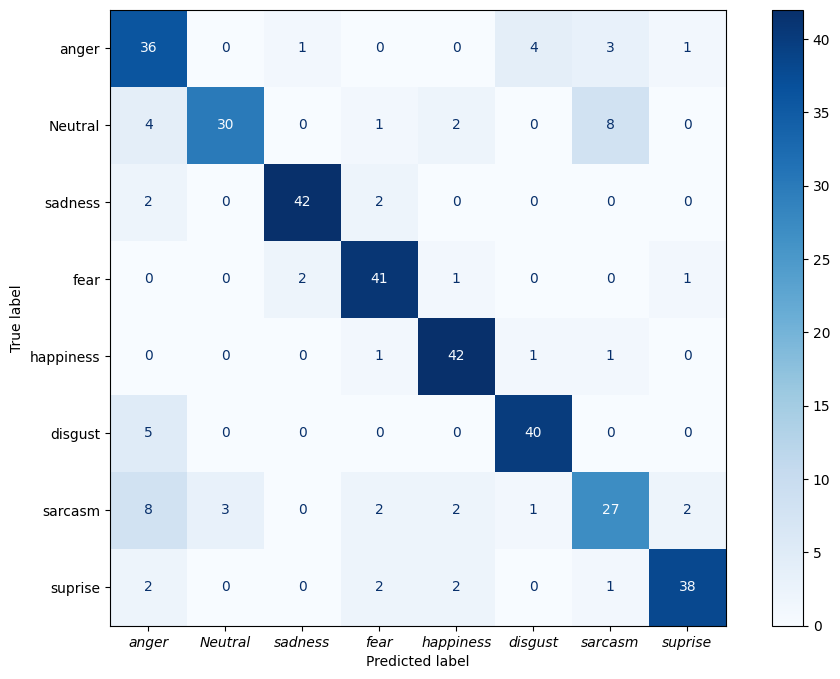

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate confusion matrix
cm = confusion_matrix(y_true=tests, y_pred=preds, labels=list(label_map))

# Display confusion matrix with color customization
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map))
fig, ax = plt.subplots(figsize=(12, 8))

# Specify colormap to transition from blue to gray
cmd.plot(ax=ax, cmap='Blues', values_format='')  # Change 'Blues' to any desired colormap

# Customize display labels
ax.set_xticklabels(cmd.display_labels, fontstyle='italic')

plt.show()

## Model Testing

In [45]:
texts = [
    "تجربة غريبة، بعض الجوانب إيجابية وبعضها سلبي.",
    "المنتج رائع ويستحق كل ريال دفعته، أنا سعيد جداً.",
    "خيبة أمل كبيرة، لم يفي بالتوقعات.",
    "الطقس جميل اليوم، يبدو أن الشمس ستشرق بقوة.",
    "أحب أن أقضي وقتي في القراءة، فهي تسلية مفيدة ومثرية.",
    "الحياة مليئة بالتحديات والفرص، علينا أن نتعلم كيف نستفيد منها.",
    "الصداقة تعني أن تكون هناك لصديقك في أوقات السراء والضراء.",
    "لدي الكثير من الأحلام والأهداف التي أسعى لتحقيقها في حياتي.",
    "الحمد لله على كل نعمة ونسأله المزيد من الرحمة والبركات.",
    "أحب السفر واستكشاف العالم الجديد، فالحياة قصيرة وعلينا الاستمتاع بها.",
    "التعليم هو المفتاح لتحقيق النجاح والتقدم في الحياة.",
    "الصبر مفتاح الفرج، وعلى الإنسان أن يثبت وقت الضيق والاختبارات.",
    "الأسرة هي الملاذ الآمن الذي نلجأ إليه في أوقات الضيق والحاجة.",
    "أحب الطبيعة والتجول في الغابات والجبال، فهي تمنحني السلام والهدوء.",
    "النجاح لا يأتي بالصدفة، بل يتطلب العمل الجاد والإصرار على تحقيق الأهداف.",
    "أشعر بالامتنان لكل لحظة أعيشها، فالحياة قدر ونعمة من الله.",
    "أحب أن أمضي وقتاً ممتعاً مع الأصدقاء والعائلة، فهم يمنحوني الفرح والسعادة.",
    "الابتسامة تعبر عن حالة الروح، فلنبتسم دائماً ونكون متفائلين بالحياة.",
    "العمل الجماعي هو مفتاح النجاح في العديد من المجالات، فلنعمل معاً من أجل الازدهار.",
    "أحب أن أبذل قصارى جهدي في كل ما أقوم به، فالتفاني والاجتهاد يأتيان بالثمار.",
    "الاعتزاز بالهوية والثقافة الخاصة بنا هو جزء من تكوين شخصيتنا وهويتنا.",
    "التفاؤل هو مفتاح النجاح في الحياة، فلنبقى متفائلين ونثق بقدرتنا على تحقيق الأهداف.",
    "التسامح والعفو هما صفات تعكس النضج الروحي والقوة الداخلية.",
    "الحياة قصيرة، لذا علينا أن نستمتع بكل لحظة ونحقق أحلامنا قبل فوات الأوان.",
    "النجاح ليس نهاية الطريق، بل هو بداية رحلة جديدة نبدأها بثقة وتفاؤل.",
    "الحمد لله على كل شيء، حتى الصعاب التي تواجهنا تجعلنا أقوى وأكثر إيماناً.",
    "المعرفة هي السلاح الأقوى الذي يمكننا استخدامه لتغيير العالم إلى الأفضل.",
    "الصحة هي أغلى ما نملك، فلنحافظ عليها بالعناية والاهتمام اللازمين.",
    "الحب والتفاهم هما أساس العلاقات القوية والمستدامة.",
    "النجاح ليس متاحاً فقط لبعض الناس، بل لأي شخص يعمل بجد وإصرار على تحقيق أهدافه.",
    "العمل التطوعي هو فرصة لنكون عوناً للآخرين ونساهم في بناء مجتمع أفضل.",
    "الصدق والامانة هما أساس الثقة والاحترام في العلاقات الإنسانية.",
    "التسامح والتعايش السلمي هما مفتاح السلام والاستقرار في العالم.",
    "التعلم المستمر هو سر التطور والنمو الشخصي، فلنبقى متعلمين طوال الحياة.",
    "المثابرة والإصرار هما الطريق إلى تحقيق الأهداف والتغلب على الصعاب.",
    "التنوع هو ما يجعل الحياة مثيرة ومليئة بالمفاجآت والتحديات.",
    "الاحترام المتبادل هو أساس العلاقات الإنسانية الصحية والمستدامة.",
    "الابتكار والإبداع هما ما يدفع العالم إلى الأمام ويحقق التقدم والازدهار.",
    "التفكير الإيجابي هو مفتاح النجاح والسعادة في الحياة.",
    "العمل الجماعي والتعاون هما ما يحقق النجاح في أي مجال نعمل فيه.",
    "العلم والمعرفة هما سلاحنا الأقوى في مواجهة التحديات وتحقيق النجاح.",
    "الاستماع بتمعن والتفاهم الجيد هما مفتاح العلاقات الناجحة والمثمرة.",
    "التفاؤل هو ما يجعل الحياة جميلة ومليئة بالأمل والتفاؤل.",
    "التسامح والتعايش السلمي هما ما يحقق السلام والاستقرار في العالم.",
]




In [46]:
trial = [
"الحمد لله على كل لحظة جميلة في حياتي، فالفرح يملأ قلبي بالسعادة." ,
"أشعر بالبهجة والسرور عندما أرى أحبائي يبتسمون ويضحكون معي." ,
"الحياة مليئة بالأمل والفرح، وأنا ممتن لكل نعمة ولحظة سعيدة." ,
"أستمتع بكل لحظة وأجعل كل يوم في حياتي مميزًا بالفرح والإيجابية." ,
"النجاح والتحقيقات الصغيرة تجلب لي الفرحة الحقيقية والشعور بالإنجاز." ,
"عندما أرى الورود تفتح أزهارها وتنشر رائحتها العطرة، يمتلئ قلبي بالفرح والسرور." ,
"الضحك هو أفضل العلاجات، فأحب أن أمضي وقتًا ممتعًا مع الأصدقاء وأضحك بلا حدود." ,
"أسعد عندما أتمكن من مساعدة الآخرين ورؤية ابتسامتهم وشكرهم لي." ,
"الأوقات السعيدة مثل النجوم في السماء، تضيء لنا الطريق في ليالي الظلام." ,
"الفرحة تكمن في اللحظات البسيطة، فأحب التمتع بجمال الطبيعة وسحرها.",
"أشعر بالحزن والأسى لفقدان شخص عزيز عليَّ وعدم قدرتي على رؤيته مرة أخرى." ,
"الحياة تبدو مظلمة ولا معنى لها بدون الشخص الذي أحبه وفقدته." ,
"الحزن يملأ قلبي عندما أتذكر الذكريات الجميلة التي لن تعود مرة أخرى." ,
"أشعر بالوحدة والعزلة رغم وجود الكثير من الناس حولي، فقلبي مشتاق للحنان والدفء." ,
"اليأس يسيطر على قلبي ولا أجد أي أمل في غدٍ أفضل بسبب الظروف الصعبة التي نعيشها." ,
"الحياة بدون أهداف وأحلام تشبه الجحيم، فأشعر بالضيق واليأس من عدم قدرتي على تحقيق أمانيي." ,
"كل يوم يمر يزداد شعوري بالضيق والحزن، ولا أجد أي مخرج لمشاكلي." ,
"أشعر بالحنين للأيام الجميلة التي مضت وللأشخاص الذين رحلوا عني، وهذا يجلب لي الحزن العميق." ,
"لا أجد متنفسًا لحزني ولا من يفهمني ويشاركني في معاناتي، فأشعر بالوحدة الكاملة." ,
"الدموع تغمر عيني وقلبي ممزق من الألم والحزن، فأتمنى لو يمكنني نسيان كل ما جرى." ,
"أنت الشخص الذي يملأ قلبي بالحب والسعادة، ولا أستطيع التخلي عنك أبدًا." ,
"حبك يجعلني أشعر بالكمال والاكتمال، فأنت كل ما أحتاجه في هذه الحياة." ,
"أشعر بالسعادة الحقيقية عندما أكون بجانبك، فأنت تضيء حياتي بضوء الحب والدفء." ,
"أنت النجم الساطع في سماء حياتي، وحبك يمنحني القوة والإلهام لمواجهة كل التحديات." ,
"عندما أنظر إليك، أشعر بالسكون والسعادة تملأ قلبي، فأنت الشخص الذي يجعلني أشعر بالحب الحقيقي." ,
"أشعر بالفرح والارتياح عندما أقضي وقتًا مميزًا معك، فأنت الشخص الذي يعرف كيف يسعدني." ,
"حبك يمنحني الطاقة والإرادة لتحقيق أحلامي وتحقيق أهدافي، فأنت دافعي للأمام." ,
"عندما أسمع صوتك، ينبض قلبي بالحب والفرح، فأنت اللحن الجميل في حياتي." ,
"أحبك بكل ما أوتيت من قوة وبكل تفاصيلك الجميلة، فأنت الشخص الذي يملأ حياتي بالسعادة." ,
"أتمنى لو يستمر هذا الحب وهذا الاحترام بيننا إلى الأبد، فأنت الشخص الذي أريد أن أقضي حياتي معه." ,
"الغضب يغمرني عندما أرى الظلم والفساد ينتشر في المجتمع من دون عقاب." ,
"أشعر بالغضب الشديد عندما أرى الظلم يحدث للأبرياء دون سبب واضح." ,
"كلما أتذكر الظلم والإهمال الذي تعرضت له، ينهال الغضب على قلبي ولا أجد مخرجًا." ,
"أنا غاضب لأن العدالة لم تحقق، والظلم يسيطر على كل جانب من جوانب الحياة." ,
"الغضب يملأ قلبي عندما أشاهد الفساد والفساد ينتشر دون رقابة أو تدخل فعال." ,
"أشعر بالغضب والاستياء من تصرفات البشر البغيضة التي تؤثر سلبًا على الآخرين." ,
"الغضب يسيطر على عقلي ولا أستطيع التحكم في نفسي عندما أشاهد الظلم والفساد ينتشر بحرية." ,
"أشعر بالغضب الشديد عندما أشاهد القوى الفاسدة تستغل الضعفاء لصالحها الشخصي." ,
"كلما تفكرت في الظلم الذي تعرضت له، كلما زادت مشاعر الغضب والانزعاج في داخلي." ,
"الغضب يسيطر على عقلي ولا أستطيع التفكير بوضوح عندما أشاهد الظلم يسود في كل مكان." ,
"أشعر بالخوف والقلق عندما أفكر في المستقبل وما قد يحمله من مفاجآت وتحديات." ,
"الخوف يسيطر على قلبي عندما أفكر في مخاطر الحياة وما قد يتعرض له أحبائي." ,
"الخوف يملأ قلبي عندما أتذكر التجارب السيئة التي مررت بها في الماضي." ,
"أشعر بالخوف والرهبة عندما أواجه مواقف غير مألوفة وخطيرة." ,
"الخوف يجعلني غير قادر على اتخاذ القرارات الصعبة والتصرف بوعي في الظروف الصعبة." ,
"الخوف يسيطر على عقلي عندما أتوقع السيناريوهات السلبية التي قد تحدث في المستقبل." ,
"أشعر بالرهبة والخوف من مواجهة المشاكل والتحديات الكبيرة التي تنتظرني." ,
"الخوف يملأ قلبي عندما أفكر في فقدان أحبائي وعدم قدرتي على حمايتهم." ,
"أشعر بالخوف والتوتر من مواجهة المواقف الصعبة والخطيرة في حياتي اليومية." ,
"الخوف يمنعني من المغامرة والتحدي ويجعلني أتردد في خوض تجارب جديدة."


]

In [55]:
egy =[
    "مرحبا 🇸🇦 كيف الحال",
    "Hello world",
    "السلام عليكم ورحمة الله وبركاته",
    "تحياتي لكم جميعًا 🌍🇪🇬 في مصر الجميلة"
]
egy3 =[
    "مرحبا 🇸🇦 كيف الحال",
]
egy2 =["Hello world","Hello world","Hello world"]
OldLength = len(egy3)


In [63]:

input_text(egy3)


مرحبا 🇸🇦 كيف الحال {'label': 'Neutral', 'score': 0.9528476595878601}


In [59]:
processor = TextProcessor()
processed_text = processor.preprocess_text(egy)
print(processed_text)

['مرحبا علم السعودية كيف الحال', '', 'السلام عليكم ورحمة الله وبركاته', 'تحياتي لكم جميعا كرة أرضية تعرض أوروبا وإفريقيا علم مصر مصر الجميلة']


In [ ]:
!zip -r Arabic_Bert.zip Arabic_Bert